<a href="https://colab.research.google.com/github/arsh919293/arsh919293/blob/main/Home%20Depot%20Recommender%20System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Home depot recommendation system**

### **Lambton College**

#### **Students**
*   Siva Pavan Kumar Pothireddy (c0790652)
*   David Camilo Espitia        (c0785089)
*   Arshdeep Singh              (c0793752)
*   Mehmet Onur                 (c0768661)



## **Data description**

This data set contains a number of products and real customer search terms from Home Depot's website.

The challenge is to predict a relevance score for the provided combinations of search terms and products. To create the ground truth labels, Home Depot has crowdsourced the search/product pairs to multiple human raters.


In [ ]:
!pip install fuzzywuzzy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import seaborn as sns
import urllib.request
import zipfile
import nltk
import string
import re
import pickle


from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer
from fuzzywuzzy import fuzz
from fuzzywuzzy import process


/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
#############
# Constants #
#############

#
# Encoding
#
ISO_8859_1_ENCODING = 'ISO-8859-1'

#
# URLs
#
ATTRIBUTE_DATA_URL = 'https://recommender-system-home-depot.s3-sa-east-1.amazonaws.com/attributes.csv.zip'
PRODUCT_DESCRIPTION_DATA_URL = 'https://recommender-system-home-depot.s3-sa-east-1.amazonaws.com/product_descriptions.csv.zip'
DATA_URL = 'https://recommender-system-home-depot.s3-sa-east-1.amazonaws.com/home-depot-data.csv'
TEST_DATA_URL = 'https://recommender-system-home-depot.s3-sa-east-1.amazonaws.com/test.csv.zip'


## **Load Data**

In [ ]:
def read_zip_csv_from_url(url:str, zip_name:str, csv_name:str, encoding=None):
  urllib.request.urlretrieve(url, zip_name)
  zip_file = zipfile.ZipFile(zip_name)
  return pd.read_csv(zip_file.open(csv_name), encoding=encoding)

In [ ]:
attribute_data = read_zip_csv_from_url(ATTRIBUTE_DATA_URL, 'attributes.csv.zip', 'attributes.csv')

In [ ]:
product_description_data = read_zip_csv_from_url(PRODUCT_DESCRIPTION_DATA_URL, 'product_descriptions.csv.zip', 'product_descriptions.csv')

In [ ]:
data = pd.read_csv(DATA_URL, encoding=ISO_8859_1_ENCODING)

In [ ]:
test_data = read_zip_csv_from_url(TEST_DATA_URL, 'test.csv.zip', 'test.csv', ISO_8859_1_ENCODING)

## **Data analysis**

In [ ]:
full_data = pd.concat((data, test_data), axis=0, ignore_index=True)

In [ ]:
full_data.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [ ]:
attribute_data.head()

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90° connection...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


In [ ]:
product_description_data.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [ ]:
full_data['relevance'].describe()

count    74067.000000
mean         2.381634
std          0.533984
min          1.000000
25%          2.000000
50%          2.330000
75%          3.000000
max          3.000000
Name: relevance, dtype: float64

### **Products information**

*   Total products
*   Products relevance

**Total products**

In [ ]:
total_products = len(product_description_data['product_uid'].unique())

print(f'Total products: {total_products}')

Total products: 124428


In [ ]:
total_products_searched_by_users = len(full_data['product_uid'].unique())

print(f'Total products searched by users: {total_products}')

Total products searched by users: 124428


**Products relevance**
*   Not relevant    = 1
*   Middly relevant = 2
*   Highly relevant = 3


In [ ]:
#
# Relevance filter
#
no_relevant_filter = lambda frame: (frame['relevance'] >= 1) & (frame['relevance'] < 2)
middly_relevant_filter = lambda frame: (frame['relevance'] >= 2) & (frame['relevance'] < 3)
highly_relevant_filter = lambda frame: (frame['relevance'] >= 3)

def get_relevance_count(dataframe, filter):
  return dataframe[filter(dataframe)].count()[0]

In [ ]:
count_no_relevant_products = get_relevance_count(full_data, no_relevant_filter)
count_middly_relevant_products = get_relevance_count(full_data, middly_relevant_filter)
count_highly_relevant_products = get_relevance_count(full_data, highly_relevant_filter)

print(f'No relevant products: {count_no_relevant_products}')
print(f'Middly relevant products: {count_middly_relevant_products}')
print(f'Highly relevant products: {count_highly_relevant_products}')

No relevant products: 11909
Middly relevant products: 43033
Highly relevant products: 19125


(0.8999999999999999, 3.1, 0.0, 20081.25)

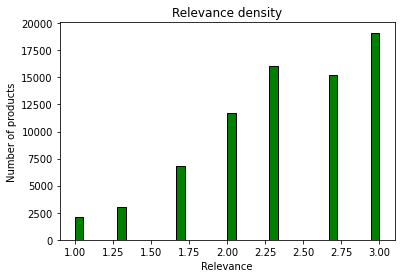

In [ ]:
data_to_plot = full_data['relevance']

plt.hist(data_to_plot, color='green', edgecolor='black', bins=int(180/5))
plt.title('Relevance density')
plt.xlabel('Relevance')
plt.ylabel('Number of products')
plt.axis()

### **Null validation on Data**

In [ ]:
full_data.isnull().sum()

id                    0
product_uid           0
product_title         0
search_term           0
relevance        166693
dtype: int64

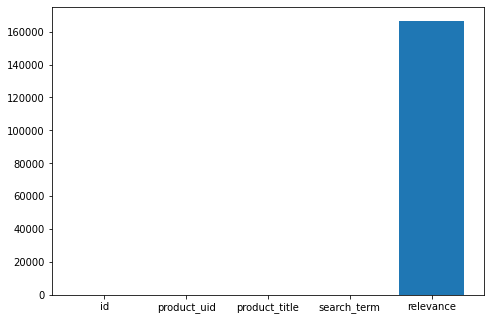

In [ ]:
fig, ax = plt.subplots()
ax = fig.add_axes([0,0,1,1])
ax.bar(full_data.columns,full_data.isnull().sum())
plt.show()

In [ ]:
#The X feature consists of strings and, ideally, 
#we should clean them up by removing all punctuation and converting all the words to lowercase """

**Merge data sets**

In [ ]:
#
# We have merged the both data set using the product_uid column
# 1. The data set with the columns (product_uid, product_title, search_term, and relevance)
# 2. The data set with the columns (product_uid, and product_description)
#
data_merged = pd.merge(full_data, product_description_data, how='left', on='product_uid')
data_merged.head()

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...


## **Data cleaning**
**Clean text columns**

In [ ]:
# This function allow us increase the column width displayed by Pandas module
pd.set_option('display.max_colwidth', 100)

#
# We are going to execute stemming and lemmatization process on product title, product description, and search term columns.
# For stemming, we are using SnowballStemmer algorithm.
# For lemmatization, WordNetLemmatizer.
#
stemmer = SnowballStemmer('english')

nltk.download('wordnet')
lemmatizer = nltk.WordNetLemmatizer()

#
# We are going to remove stop words on some columns as well
#
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#
# We have defined the next functions to clean text columns which allows us extract features in the future steps
#
def remove_punctuation(text):
  text_no_punctuation = "".join([char for char in text if char not in string.punctuation])
  return text_no_punctuation

def tokenize(text):
  tokens = re.split('\W', text)
  return tokens

def remove_stopwords(words_list):
  return [word for word in words_list if word not in stopwords]

def stem_words(words):
    words_lower = words.lower().split()
    return " ".join([stemmer.stem(word) for word in words_lower])

def lemmatize_words(words):
  return " ".join([lemmatizer.lemmatize(word) for word in words])

#
# This function will execute all clean process on each column.
# 1. turn text to lower case
# 2. remove punctuationes
# 3. tokenize 
# 4. remove stopwords
# 5. execute lemmatizing process
#
def clean_text(text):
  new_text = text.lower()
  new_text = remove_punctuation(new_text)
  tokens = tokenize(new_text)
  tokens = remove_stopwords(tokens)
  new_text = lemmatize_words(tokens)
  return new_text

**Add features**

In [ ]:
#
# Clean product_title and create a new column named product_title_cleaned
#

def create_product_title_cleaned(data_frame):
  data_frame['product_title_cleaned'] = data_frame['product_title'].map(lambda x:clean_text(x))

create_product_title_cleaned(data_merged) 
data_merged[['product_title','product_title_cleaned']].head(10)

,product_title,product_title_cleaned
0,Simpson Strong-Tie 12-Gauge Angle,simpson strongtie 12gauge angle
1,Simpson Strong-Tie 12-Gauge Angle,simpson strongtie 12gauge angle
2,BEHR Premium Textured DeckOver 1-gal. #SC-141 Tugboat Wood and Concrete Coating,behr premium textured deckover 1gal sc141 tugboat wood concrete coating
3,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included),delta vero 1handle shower faucet trim kit chrome valve included
4,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included),delta vero 1handle shower faucet trim kit chrome valve included
5,Whirlpool 1.9 cu. ft. Over the Range Convection Microwave in Stainless Steel with Sensor Cooking,whirlpool 19 cu ft range convection microwave stainless steel sensor cooking
6,Whirlpool 1.9 cu. ft. Over the Range Convection Microwave in Stainless Steel with Sensor Cooking,whirlpool 19 cu ft range convection microwave stainless steel sensor cooking
7,Whirlpool 1.9 cu. ft. Over the Range Convection Microwave in Stainless Steel with Sensor Cooking,whirlpool 19 cu ft range convection microwave stainless steel sensor cooking
8,Lithonia Lighting Quantum 2-Light Black LED Emergency Fixture Unit,lithonia lighting quantum 2light black led emergency fixture unit
9,House of Fara 3/4 in. x 3 in. x 8 ft. MDF Fluted Casing,house fara 34 x 3 x 8 ft mdf fluted casing


In [ ]:
#
# Clean search_term and create a new column named search_term_cleaned
#
#data_merged['search_term_cleaned'] = data_merged['search_term'].map(lambda x:clean_text(x))

def create_search_term_cleaned(data_frame):
  data_frame['search_term_cleaned'] = data_frame['search_term'].map(lambda x:clean_text(x))

create_search_term_cleaned(data_merged)
data_merged[['search_term','search_term_cleaned']].head(10)

,search_term,search_term_cleaned
0,angle bracket,angle bracket
1,l bracket,l bracket
2,deck over,deck
3,rain shower head,rain shower head
4,shower only faucet,shower faucet
5,convection otr,convection otr
6,microwave over stove,microwave stove
7,microwaves,microwave
8,emergency light,emergency light
9,mdf 3/4,mdf 34


In [ ]:
#
# Clean product_description and create a new column named product_description_cleaned
#
#data_merged['product_description_cleaned'] = data_merged['product_description'].map(lambda x:clean_text(x))
#data_merged[['product_description','product_description_cleaned']].head()

def create_product_description_cleaned(data_frame):
  data_frame['product_description_cleaned'] = data_frame['product_description'].map(lambda x:clean_text(x))

create_product_description_cleaned(data_merged)
data_merged[['product_description','product_description_cleaned']].head()

,product_description,product_description_cleaned
0,"Not only do angles make joints stronger, they also provide more consistent, straight corners. Si...",angle make joint stronger also provide consistent straight corner simpson strongtie offer wide v...
1,"Not only do angles make joints stronger, they also provide more consistent, straight corners. Si...",angle make joint stronger also provide consistent straight corner simpson strongtie offer wide v...
2,"BEHR Premium Textured DECKOVER is an innovative solid color coating. It will bring your old, wea...",behr premium textured deckover innovative solid color coating bring old weathered wood concrete ...
3,Update your bathroom with the Delta Vero Single-Handle Shower Faucet Trim Kit in Chrome. It has ...,update bathroom delta vero singlehandle shower faucet trim kit chrome sleek modern minimalistic ...
4,Update your bathroom with the Delta Vero Single-Handle Shower Faucet Trim Kit in Chrome. It has ...,update bathroom delta vero singlehandle shower faucet trim kit chrome sleek modern minimalistic ...


In [ ]:
#
# We will create a new feature column with the lenght or number of words in the search term
#
#data_merged['seacrh_term_length'] = data_merged['search_term'].map(lambda x:len(x.split())).astype(np.int64)
#data_merged[['search_term', 'seacrh_term_length']].head()

def create_search_term_length(data_frame):
  data_frame['seacrh_term_length'] = data_frame['search_term'].map(lambda x:len(x.split())).astype(np.int64)

create_search_term_length(data_merged)
data_merged[['search_term', 'seacrh_term_length']].head()

,search_term,seacrh_term_length
0,angle bracket,2
1,l bracket,2
2,deck over,2
3,rain shower head,3
4,shower only faucet,3


In [ ]:
#
# Function to count hits of a word in a text
#
def count_hit_words(search_words, target):
  return sum(int(target.find(word) >= 0) for word in search_words.split())

In [ ]:
#
# We add a new feature column with the number of search term words present in the product title 
#
#data_merged['hits_words_in_title'] = (data_merged['search_term_cleaned'] + "\t" + data_merged['product_title_cleaned']) \
#  .map(lambda x: count_hit_words(x.split('\t')[0],x.split('\t')[1]))

def create_hits_words_in_title(data_frame):
  data_frame['hits_words_in_title'] = (data_frame['search_term_cleaned'] + "\t" + data_frame['product_title_cleaned']) \
  .map(lambda x: count_hit_words(x.split('\t')[0],x.split('\t')[1]))

create_hits_words_in_title(data_merged)
data_merged[['search_term_cleaned', 'product_title_cleaned', 'hits_words_in_title']]


,search_term_cleaned,product_title_cleaned,hits_words_in_title
0,angle bracket,simpson strongtie 12gauge angle,1
1,l bracket,simpson strongtie 12gauge angle,1
2,deck,behr premium textured deckover 1gal sc141 tugboat wood concrete coating,1
3,rain shower head,delta vero 1handle shower faucet trim kit chrome valve included,1
4,shower faucet,delta vero 1handle shower faucet trim kit chrome valve included,2
...,...,...,...
240755,24 whtie storage cabinet,stufurhome norma 24 w x 16 x 34 h linen storage floor cabinet white,3
240756,adirondeck cusion,home decorator collection 49 alessandro spiceberry polyester montauk adirondack bullnose outdoor...,0
240757,hb,simpson strongtie hb 312 x 14 top flange ijoist hanger,1
240758,hex socket,14 20 tpi x 112 stainless steel buttonhead internal hex socket cap screw 2 per pack,2


In [ ]:
#
# We add a new feature column with the number of search term words present in the product description 
#
#data_merged['hits_words_in_description'] = (data_merged['search_term_cleaned'] + "\t" + data_merged['product_description_cleaned']) \
#  .map(lambda x: count_hit_words(x.split('\t')[0],x.split('\t')[1]))

def create_hits_words_in_description(data_frame):
  data_frame['hits_words_in_description'] = (data_frame['search_term_cleaned'] + "\t" + data_frame['product_description_cleaned']) \
  .map(lambda x: count_hit_words(x.split('\t')[0],x.split('\t')[1]))

create_hits_words_in_description(data_merged)
data_merged[['search_term_cleaned', 'product_description_cleaned', 'hits_words_in_description']]


,search_term_cleaned,product_description_cleaned,hits_words_in_description
0,angle bracket,angle make joint stronger also provide consistent straight corner simpson strongtie offer wide v...,1
1,l bracket,angle make joint stronger also provide consistent straight corner simpson strongtie offer wide v...,1
2,deck,behr premium textured deckover innovative solid color coating bring old weathered wood concrete ...,1
3,rain shower head,update bathroom delta vero singlehandle shower faucet trim kit chrome sleek modern minimalistic ...,1
4,shower faucet,update bathroom delta vero singlehandle shower faucet trim kit chrome sleek modern minimalistic ...,2
...,...,...,...
240755,24 whtie storage cabinet,create neat yet stylish storage space organizing bathroom essential stufurhome norma 24 linen ca...,3
240756,adirondeck cusion,bullnose adirondack chair cushion fit adirondack chair loveseat requires two rocker offer variet...,0
240757,hb,joist hanger designed provide support underneath joist rafter beam provide strong connection sim...,1
240758,hex socket,socket cap screw ideal application require well tooled appearance broader bearing surface screw ...,2


In [ ]:
#
# It is the dataset with all features created until now
#
data_merged.head()

,id,product_uid,product_title,search_term,relevance,product_description,product_title_cleaned,search_term_cleaned,product_description_cleaned,seacrh_term_length,hits_words_in_title,hits_words_in_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they also provide more consistent, straight corners. Si...",simpson strongtie 12gauge angle,angle bracket,angle make joint stronger also provide consistent straight corner simpson strongtie offer wide v...,2,1,1
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they also provide more consistent, straight corners. Si...",simpson strongtie 12gauge angle,l bracket,angle make joint stronger also provide consistent straight corner simpson strongtie offer wide v...,2,1,1
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 Tugboat Wood and Concrete Coating,deck over,3.00,"BEHR Premium Textured DECKOVER is an innovative solid color coating. It will bring your old, wea...",behr premium textured deckover 1gal sc141 tugboat wood concrete coating,deck,behr premium textured deckover innovative solid color coating bring old weathered wood concrete ...,2,1,1
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included),rain shower head,2.33,Update your bathroom with the Delta Vero Single-Handle Shower Faucet Trim Kit in Chrome. It has ...,delta vero 1handle shower faucet trim kit chrome valve included,rain shower head,update bathroom delta vero singlehandle shower faucet trim kit chrome sleek modern minimalistic ...,3,1,1
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included),shower only faucet,2.67,Update your bathroom with the Delta Vero Single-Handle Shower Faucet Trim Kit in Chrome. It has ...,delta vero 1handle shower faucet trim kit chrome valve included,shower faucet,update bathroom delta vero singlehandle shower faucet trim kit chrome sleek modern minimalistic ...,3,2,2


In [ ]:
def calculate_partial_ratio(text_a , text_b):
    return fuzz.partial_ratio(text_a, text_b)

def calculate_token_sort_ratio(text_a,text_b):
    return fuzz.token_sort_ratio(text_a,text_b)

In [ ]:
#
# Calculate the ratio on 'search_term' and 'product_title' 
#
# fuzzy_token_sort_ratio_in_title
#search_term_plus_product_title = (data_merged['search_term_cleaned'] + "\t" + data_merged['product_title_cleaned'])

def create_ratio_in_title(data_frame):
  search_term_plus_product_title = (data_frame['search_term_cleaned'] + "\t" + data_frame['product_title_cleaned'])
  data_frame['ratio_in_title'] = search_term_plus_product_title.map(lambda x: calculate_partial_ratio(x.split('\t')[0],x.split('\t')[1]))
  data_frame['token_sort_ratio_in_title'] = search_term_plus_product_title.map(lambda x: calculate_token_sort_ratio(x.split('\t')[0],x.split('\t')[1]))

create_ratio_in_title(data_merged)

In [ ]:
#
# Calculate the ratio on 'search_term' and 'product_description' 
#

def create_ratio_in_description(data_frame):
  search_term_plus_product_description = (data_frame['search_term_cleaned'] + "\t" + data_frame['product_description_cleaned'])
  data_frame['ratio_in_description'] = search_term_plus_product_description.map(lambda x: calculate_partial_ratio(x.split('\t')[0],x.split('\t')[1]))
  data_frame['token_sort_ratio_in_description'] = search_term_plus_product_description.map(lambda x: calculate_token_sort_ratio(x.split('\t')[0],x.split('\t')[1]))

create_ratio_in_description(data_merged)

In [ ]:
data_merged[['search_term_cleaned', 'product_title_cleaned', 
             'product_description_cleaned', 'ratio_in_title', 
             'token_sort_ratio_in_title', 'ratio_in_description', 
             'token_sort_ratio_in_description']].head(5)

,search_term_cleaned,product_title_cleaned,product_description_cleaned,ratio_in_title,token_sort_ratio_in_title,ratio_in_description,token_sort_ratio_in_description
0,angle bracket,simpson strongtie 12gauge angle,angle make joint stronger also provide consistent straight corner simpson strongtie offer wide v...,56,36,69,1
1,l bracket,simpson strongtie 12gauge angle,angle make joint stronger also provide consistent straight corner simpson strongtie offer wide v...,36,10,33,1
2,deck,behr premium textured deckover 1gal sc141 tugboat wood concrete coating,behr premium textured deckover innovative solid color coating bring old weathered wood concrete ...,100,11,0,0
3,rain shower head,delta vero 1handle shower faucet trim kit chrome valve included,update bathroom delta vero singlehandle shower faucet trim kit chrome sleek modern minimalistic ...,69,33,19,0
4,shower faucet,delta vero 1handle shower faucet trim kit chrome valve included,update bathroom delta vero singlehandle shower faucet trim kit chrome sleek modern minimalistic ...,100,34,100,0


# **Predictions models**

We implemented four different models to predict the relevance value, which is the value used to return the ten top products recommended depends on what the user is looking for buying.


*   Random forest regressor and Bagging regressor classifier
*   XGboost
*   XGboost and GridSearch CV
*   Linear regression 

### **Random Forest Regressor and Bagging regressor classifier**

The first model is focused on an ensemble method to combine the predictions of some base estimators built with a given learning algorithm to improve generalizability over a single estimator.

There are two types:

* Averaging methods are to build several estimators independently and then to 
average their predictions.

* Boosting methods are built sequentially, and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble.

In [ ]:
# Split dataset for training and testing 
df_train = data_merged.iloc[:74067]
df_test = data_merged[74067:]

Our target column in the dataset is the relevance value; therefore, we saved the values in a new variable. We are also removing the columns not needed for training the model. We'll use only the features extracted from them.

In [ ]:
# This is the target column
y_train = df_train['relevance'].values

In [ ]:
# These columns must be removed before to train the model
columns_to_remove = ['id',
                     'product_title_cleaned',
                     'search_term_cleaned',
                     'product_description_cleaned',
                     'search_term',
                     'product_title',
                     'product_description',
                     'product_info' ,
                     'relevance', 
                     'product_uid']

In [ ]:
# Convert values to numpy array
X_train = df_train[[w for w in list(df_train.columns) if w not in columns_to_remove]].values
X_test = df_test[[w for w in list(df_test.columns) if w not in columns_to_remove]].values

* We defined the random forest regressor; basically, it is a meta estimator that fits a number of classifying decision trees on various samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

* We are using a simple configuration.
Five thin estimators, it means the number of trees in the forest.
The maximum depth of the tree is six.
And  zero random state, it controls both the randomness of the bootstrapping.

In [ ]:
# Define the regressor model to be used with bagging classifier
#
# n_estimators: The number of trees in the forest.
# max_depth: The maximum depth of the tree.
# random_state: Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True).
randomForestRegressor = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)

* The bagging regressor uses the random forest inside of this. It is to reduce the variance of a black box estimator introducing randomization into its construction procedure and then making an ensemble out of it.

In [ ]:
# Instance Bagging classifier
bagging_classifier = BaggingRegressor(randomForestRegressor, n_estimators=45, max_samples=0.1, random_state=25)

In [ ]:
bagging_classifier.fit(X_train, y_train)

BaggingRegressor(base_estimator=RandomForestRegressor(bootstrap=True,
                                                      ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=6,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      max_samples=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=15,
                                     

In [ ]:
# Predict X_test and X_train
y_pred = bagging_classifier.predict(X_test)
y_true_pred = bagging_classifier.predict(X_train)

In [ ]:
# Print out the predictions from X_test and save it in a CSV file
id_test = df_test['id']
search_term_test = df_test['search_term']
product_title_test = df_test['product_title']
df_result_predictions = pd.DataFrame({"id": id_test, "product_title": product_title_test, "search_term": search_term_test, "relevance": y_pred})

df_result_predictions.to_csv('prediction.csv',index=False)

In [ ]:
df_result_predictions.head(20)

,id,product_title,search_term,relevance
74067,1,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,1.937627
74068,4,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,1.954217
74069,5,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,2.247986
74070,6,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,2.715604
74071,7,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,2.443963
74072,8,Simpson Strong-Tie 12-Gauge Angle,wood connectors,2.099085
74073,10,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4 in. Bath and Shower Kit with Right-Hand Drain in ...,bath and shower kit,2.606126
74074,11,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4 in. Bath and Shower Kit with Right-Hand Drain in ...,bath drain kit,2.680943
74075,12,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4 in. Bath and Shower Kit with Right-Hand Drain in ...,one piece tub shower,2.028236
74076,13,Grape Solar 265-Watt Polycrystalline Solar Panel (4-Pack),solar panel,2.718711


### **Xgboost**

* It is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. It is also used for solving many data science problems in a fast and accurate way.

In [ ]:
import xgboost as xgb
from sklearn.datasets import dump_svmlight_file
from xgboost import plot_importance
from sklearn.model_selection import KFold, train_test_split, GridSearchCV

In [ ]:
# Columns selected to train the model
columns_to_train = ['seacrh_term_length' , 
                    'hits_words_in_title', 
                    'hits_words_in_description' , 
                    'ratio_in_title', 
                    'ratio_in_description' , 
                    'token_sort_ratio_in_title' , 
                    'token_sort_ratio_in_description']

In [ ]:
# Y_train values
y_train_xgb = df_train['relevance'].values

# X_train and X_test
X_train_xgb = df_train[columns_to_train]
X_test_xgb = df_test[columns_to_train]
X_test_xgb

,seacrh_term_length,hits_words_in_title,hits_words_in_description,ratio_in_title,ratio_in_description,token_sort_ratio_in_title,token_sort_ratio_in_description
74067,3,0,1,29,29,12,2
74068,3,1,1,29,33,9,1
74069,3,1,1,56,31,55,1
74070,3,3,3,89,42,69,0
74071,4,3,3,72,44,64,0
...,...,...,...,...,...,...,...
240755,4,3,3,71,54,51,1
240756,2,0,0,71,71,25,1
240757,1,1,1,100,0,7,0
240758,2,2,2,100,80,22,4


* To create the Xgboost regressor, we have defined the six value as the maximum 
depth of a tree, and we kept the default value for the estimators. We also try to find a better configuration in the next step.

In [ ]:
# Instance XGboost regressor
#
# max_depth: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
# n_estimators: The number of trees (or rounds) in an XGBoost model is specified to the XGBClassifier or XGBRegressor class in the n_estimators argument. The default in the XGBoost library is 100.
#
xgboost_regressor = xgb.XGBRegressor(max_depth = 6, n_estimators = 50)



* We run the fit method on the model.
After that, we predict the values of X_train data.
On this model, we computed the Root Mean Square Error (RMSE) 
Basically, it is the standard deviation of the residuals or (prediction errors).




In [ ]:
# Fit the model
xgboost_regressor.fit(X_train_xgb , y_train_xgb)

[16:59:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
# predict X_train
y_true_xbg_pred = xgboost_regressor.predict(X_train_xgb)

In [ ]:
# Compute the Root Mean Square Error
rmse = np.sqrt(((y_train_xgb - y_true_xbg_pred) ** 2).mean())
print ('Root Mean Square Error using XGBoost Regressor: ', rmse)

Root Mean Square Error using XGBoost Regressor:  0.46922773076236396


* XGboost also allows us to see the feature importance with the function plot_importance. Here, we can see that the three most crucial features, token_sort_ratio_in_tittle, ratio_in_description, and ratio_in_title. Now, we print out the prediction result.

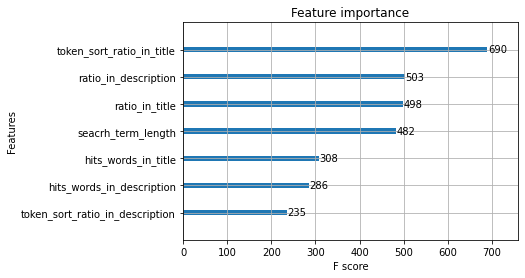

In [ ]:
# XGBoost allows us print out the feature importance 
plot_importance(xgboost_regressor)

In [ ]:
# predict X_test
y_pred_xgb = xgboost_regressor.predict(X_test_xgb)

In [ ]:
id_test = df_test['id']
search_term_test = df_test['search_term']
product_title_test = df_test['product_title']
df_result_predictions_xgb = pd.DataFrame({"id": id_test, "product_title": product_title_test, "search_term": search_term_test, "relevance": y_pred_xgb})

df_result_predictions_xgb.to_csv('prediction_xgb.csv',index=False)

In [ ]:
df_result_predictions_xgb.head(20)

,id,product_title,search_term,relevance
74067,1,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,1.808156
74068,4,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,1.875739
74069,5,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,2.259676
74070,6,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,2.694372
74071,7,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,2.458611
74072,8,Simpson Strong-Tie 12-Gauge Angle,wood connectors,2.147903
74073,10,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4 in. Bath and Shower Kit with Right-Hand Drain in ...,bath and shower kit,2.437069
74074,11,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4 in. Bath and Shower Kit with Right-Hand Drain in ...,bath drain kit,2.587057
74075,12,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4 in. Bath and Shower Kit with Right-Hand Drain in ...,one piece tub shower,1.928386
74076,13,Grape Solar 265-Watt Polycrystalline Solar Panel (4-Pack),solar panel,2.709614


### **XGboost with GridSearch**

* What is GridSearch?
It is a tuning technique that attempts to compute the optimum values of hyperparameters. It is an exhaustive search that is performed on the specific parameter values of a model. 

In [ ]:
# New XGboost regressor for using GridSearch
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

In this case, we want to test next configurations: 
* max_depth with the value 2,4,6,8
* estimators: 20, 50, 80, 100

In [ ]:
# GridSearch configuration
grid_search_cv_clf = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6,8],
                    'n_estimators': [20,50,80,100]}, verbose=1)

In [ ]:
# Fit model with GridSearch
grid_search_cv_clf.fit(X_train_xgb , y_train_xgb)

print(f'Best score: {grid_search_cv_clf.best_score_}')
print(f'Best params: {grid_search_cv_clf.best_params_}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  2.5min finished


Best score: 0.1766636852613589
Best params: {'max_depth': 6, 'n_estimators': 80}


In [ ]:
# Predict X_train
y_true_pred = grid_search_cv_clf.predict(X_train_xgb)
print ('Root Mean Square Error for all features using XGboost and GridSearch : ' , np.sqrt(((y_train - y_true_pred) ** 2).mean()))

Root Mean Square Error for all features using XGboost and GridSearch :  0.46694249691006207


In [ ]:
# Predict X_test
y_pred_xgb_2 = grid_search_cv_clf.predict(X_test_xgb)

# Print out the X_test prediction
id_test = df_test['id']
search_term_test = df_test['search_term']
product_title_test = df_test['product_title']
df_result_predictions_xgb_2 = pd.DataFrame({"id": id_test, "product_title": product_title_test, "search_term": search_term_test, "relevance": y_pred_xgb_2})

df_result_predictions_xgb_2.to_csv('prediction_xgb_2.csv',index=False)
df_result_predictions_xgb_2.head(20)

,id,product_title,search_term,relevance
74067,1,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,1.780935
74068,4,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,1.849127
74069,5,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,2.270561
74070,6,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,2.704687
74071,7,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,2.470907
74072,8,Simpson Strong-Tie 12-Gauge Angle,wood connectors,2.154611
74073,10,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4 in. Bath and Shower Kit with Right-Hand Drain in ...,bath and shower kit,2.432305
74074,11,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4 in. Bath and Shower Kit with Right-Hand Drain in ...,bath drain kit,2.603167
74075,12,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4 in. Bath and Shower Kit with Right-Hand Drain in ...,one piece tub shower,1.932534
74076,13,Grape Solar 265-Watt Polycrystalline Solar Panel (4-Pack),solar panel,2.724416


### **Linear Regression**

* Why linear regression?
Because it is probably one of the most important and widely used regression techniques. It’s among the simplest regression methods. One of its main advantages is the ease of interpreting results.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
# Instance the linear regression model  
linear_regression = LinearRegression()

In [ ]:
# Train the model
linear_regression.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Root mean square error on model
y_true_pred = linear_regression.predict(X_train)
print ('Root Mean Square Error using linear Regressor: ' , np.sqrt(((y_train - y_true_pred) ** 2).mean()))

Root Mean Square Error using linear Regressor:  0.48862857587876124


In [ ]:
# Predict X_test
y_pred_linear = linear_regression.predict(X_test)
X_test

array([[ 3,  0,  1, ..., 12, 29,  2],
       [ 3,  1,  1, ...,  9, 33,  1],
       [ 3,  1,  1, ..., 55, 31,  1],
       ...,
       [ 1,  1,  1, ...,  7,  0,  0],
       [ 2,  2,  2, ..., 22, 80,  4],
       [ 4,  3,  2, ..., 51, 67,  2]])

In [ ]:
id_test = df_test['id']
search_term_test = df_test['search_term']
product_title_test = df_test['product_title']
df_result_predictions_linear = pd.DataFrame({"id": id_test, "product_title": product_title_test, "search_term": search_term_test, "relevance": y_pred_linear})

df_result_predictions_linear.head(20)

,id,product_title,search_term,relevance
74067,1,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,1.874127
74068,4,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,1.954611
74069,5,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,2.293155
74070,6,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,2.834865
74071,7,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,2.618354
74072,8,Simpson Strong-Tie 12-Gauge Angle,wood connectors,2.043191
74073,10,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4 in. Bath and Shower Kit with Right-Hand Drain in ...,bath and shower kit,2.411992
74074,11,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4 in. Bath and Shower Kit with Right-Hand Drain in ...,bath drain kit,2.417653
74075,12,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4 in. Bath and Shower Kit with Right-Hand Drain in ...,one piece tub shower,1.931799
74076,13,Grape Solar 265-Watt Polycrystalline Solar Panel (4-Pack),solar panel,2.656223




### **Save model**

The last steps are to save, load, and test the data as a user and see all models' behavior. We define two functions for those approaches. They are using the pickle library to execute these processes.

In [ ]:
def save_model(file_name, model):
  """
  Save learning models as File
  """
  pickle.dump(model, open(file_name, 'wb'))

In [ ]:
linear_model_file_name = 'linear_regressor_model.sav'
grid_search_cv_clf_file_name = 'grid_search_cv_clf.sav'
xgboost_regressor_file_name = 'xgboost_regressor.sav' 
bagging_classifier_file_name = 'bagging_classifier.sav'

In [ ]:
# Save Linear regression model
save_model(linear_model_file_name, linear_regression)

# Save XGboost model
save_model(xgboost_regressor_file_name, xgboost_regressor)

# Save XGboost model with GridSearch
save_model(grid_search_cv_clf_file_name, grid_search_cv_clf)

# Save Random Forest Regressor and Bagging regressor classifier
save_model(bagging_classifier_file_name, bagging_classifier)

### **Load Model**

In [ ]:
def load_model(file_name):
  """
    Load a model in memory
  """
  return pickle.load(open(file_name, 'rb'))

In [ ]:
# Load Linear regression model
load_lr_model = load_model(linear_model_file_name)

# Load XGboost model with GridSearch
grid_search_model = load_model(grid_search_cv_clf_file_name)

# Load XGboost model
xgboost_regressor_model = load_model(xgboost_regressor_file_name)

# Load Random Forest Regressor and Bagging regressor classifier
bagging_classifier_model = load_model(bagging_classifier_file_name)

[17:02:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
load_lr_model.coef_

array([-0.12436798,  0.08817987,  0.07668173,  0.0039822 ,  0.00503852,
        0.00037362, -0.00592481])

In [ ]:
prediction = load_lr_model.predict(X_test)

### **Test model with only one search term**

In [ ]:
products = data_merged[['product_title_cleaned', 'product_description_cleaned']]

In [ ]:
# Remove data duplicated, we only need one record per product
products = products.drop_duplicates(subset=['product_title_cleaned'])[['product_title_cleaned','product_description_cleaned']]
products = products[:10000]

In [ ]:
def add_features(data_frame):
  """
    Function to add features on search terms.
    It prepares the data to predict relevance value with the models
  """
  create_search_term_cleaned(data_frame)
  create_search_term_length(data_frame)
  create_hits_words_in_title(data_frame)
  create_hits_words_in_description(data_frame)
  create_ratio_in_title(data_frame)
  create_ratio_in_description(data_frame)

In [ ]:
products['search_term'] = 'simpson strong tie'
#products['search_term'] ='leviton socket outlet white'
#products['search_term'] = 'soap dispenser'
#products['search_term'] = 'hex socket'


In [ ]:
add_features(products)

In [ ]:
data_to_predict_2 = products[[w for w in list(products.columns) if w not in columns_to_remove]].values

# Predict with Liner regression
prediction_2 = load_lr_model.predict(data_to_predict_2)

# Predict with XGboost
prediction_3 = xgboost_regressor_model.predict(products[columns_to_train])

# Predict with XGboost created with GridSearch
prediction_4 = grid_search_model.predict(products[columns_to_train])

# Predict with bagging classifier
prediction_5 = bagging_classifier_model.predict(products[columns_to_train])

In [ ]:
# Group all predictions
search_term_test = products['search_term']
product_title_test = products['product_title_cleaned']
product_descriptiob_test = products['product_description_cleaned']

test_predictions = pd.DataFrame({"product_title": product_title_test, 
                                        "product_description": product_descriptiob_test,
                                        "search_term": search_term_test, 
                                        "relevance_lr": prediction_2,
                                        "relevance_xboost": prediction_3,
                                        "relevance_grid": prediction_4,
                                        "relevance_bagging": prediction_5})

In [ ]:
# Print out the top 10 relevance products
test_predictions.nlargest(10, 'relevance_lr')

,product_title,product_description,search_term,relevance_lr,relevance_xboost,relevance_grid,relevance_bagging
0,simpson strongtie 12gauge angle,angle make joint stronger also provide consistent straight corner simpson strongtie offer wide v...,simpson strong tie 318,2.716655,2.529765,2.544452,2.491073
2380,simpson strongtie 2 12gauge pipe grip tie,simpson strongtie pipegrip tie make easy attach wood fence rail metal fence post galvanized fenc...,simpson strong tie 318,2.683264,2.487126,2.520319,2.489398
968,simpson strongtie 18gauge galvanized steel angle,angle make joint stronger also provide consistent straight corner simpson strongtie offer wide v...,simpson strong tie 318,2.653195,2.589876,2.601775,2.599327
4108,simpson strongtie 16gauge concrete form angle,simpson strongtie connector make project easier build making stronger safer engineered tested pe...,simpson strong tie 318,2.653033,2.475182,2.504985,2.487821
9237,simpson strongtie 14 x 112 strongdrive wood screw 50pack,simpson strongtie offer wide range fastener focused need professional builder mean focus feature...,simpson strong tie 318,2.622801,2.461518,2.491321,2.485436
14653,simpson strongtie 24 insulation support 100qty,keep insulation firmly place simpson strongtie insulation support insulation support cut carbon ...,simpson strong tie 318,2.610822,2.398440,2.406619,2.458024
18223,simpson strongtie zmax galvanized 18gauge hurricane tie,joist hanger designed provide support underneath joist rafter beam provide strong connection sim...,simpson strong tie 318,2.607278,2.418254,2.430152,2.461516
17852,simpson strongtie zmax 2 12gauge galvanized pipe grip tie,simpson strongtie pipegrip tie make easy attach wood fence rail metal fence post galvanized fenc...,simpson strong tie 318,2.606873,2.461518,2.491321,2.472380
3381,simpson strongtie cb 6x6 galvanized column base,simpson strongtie connector make project easier build making stronger safer engineered tested pe...,simpson strong tie 318,2.605986,2.443170,2.471741,2.467556
16284,simpson strongtie 12gauge black powdercoated ez spike,replacing entire fence expensive difficult task easy get fence back shape home back looking best...,simpson strong tie 318,2.605615,2.438008,2.445867,2.470038
